In [70]:
import utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.5)
from matplotlib.patches import Patch

In [71]:
# theretical lower bounds
lb_df = pd.read_csv("data/theoretical-lower-bounds.csv")\
    .rename(columns={
        "total running time":"LB_processingTime",
        "total setup costs":"LB_setupCost",
        "number of too late jobs": "LB_tardyJobs",
        "number of too late jobs (simple bound)": "LB_tardyJobs_Simple",
        "number of batches":"LB_batchCount",
        "normalised objective bound":"LB_objNormalized",

    })[["instance_number", "LB_processingTime", "LB_setupCost", "LB_tardyJobs", "LB_tardyJobs_Simple", "LB_batchCount", "LB_objNormalized", ]]
lb_df["size"] = lb_df.apply(lambda row: utils.get_size(row["instance_number"]),axis=1)
lb_df.head()

,instance_number,LB_processingTime,LB_setupCost,LB_tardyJobs,LB_tardyJobs_Simple,LB_batchCount,LB_objNormalized,size
0,1,32,10,7,7,6,0.694222,small
1,2,41,7,10,10,5,0.974127,small
2,3,41,0,2,2,6,0.216508,small
3,4,22,7,2,2,3,0.206667,small
4,5,245,56,0,0,4,0.018632,small


## Complete objective

In [72]:
# work with complete objective
df = pd.read_csv("data/all-complete.csv",sep=";")
# select optimal 
optimal_list = list(set(df.query("optimal > 0")["instance_number"].unique()))
print("total optimal:", len(optimal_list))

total optimal: 41


In [73]:
optimal_objective_df = (
    df.query("optimal >= 1")
      .query("instance_number in @optimal_list")
)[["instance_number", "solutionCosts"]].groupby(["instance_number"]).min().reset_index()
display(optimal_objective_df.head())

,instance_number,solutionCosts
0,1,0.792571
1,2,0.977937
2,3,0.225556
3,4,0.492381
4,5,0.308648


In [74]:
# checker 
tmp = (
    df.query("optimal >= 1")
      .query("instance_number in @optimal_list")
)[["instance_number", "solutionCosts"]]#.drop_duplicates(keep="first")
tmp["solutionCosts"] = round(tmp["solutionCosts"],6)
tmp.drop_duplicates(keep="first").shape

(41, 2)

In [75]:
norm_cost = pd.read_csv("data/norm-cost.csv",index_col=0)
norm_cost.head()

,instance_number,normalization_constant
0,50,2772000
1,22,15750
2,47,135712500
3,49,787500
4,43,31500


In [76]:
exact_models_with_bounds = ['opl-reprjob-LB-WS-noUB', 'mzn-gurobi-LB-noUB', 'mzn-gurobiWS-LB-noUB', 'opl-reprjob-LB-noUB']
not_optimal_df = (
    df.query("instance_number not in @optimal_list and solution_method not in @exact_models_with_bounds")
)[["instance_number","int_objective_bound"]].groupby(["instance_number"]).max().reset_index()
not_optimal_df = pd.merge(not_optimal_df, lb_df[["size","LB_objNormalized","instance_number"]], on="instance_number",how="left")
not_optimal_df = pd.merge(not_optimal_df,norm_cost,on="instance_number", how="left")
not_optimal_df["real_bound"] = not_optimal_df["int_objective_bound"]/not_optimal_df["normalization_constant"]
not_optimal_df["best"] = not_optimal_df.apply(lambda row: utils.which_better(row["real_bound"], row["LB_objNormalized"]), axis=1)
not_optimal_df[["instance_number","best","size"]].groupby(["best","size"]).count()

instance_number
best  size                   
calc. large                40
      medium               22
solv. medium               14
      small                 3

In [77]:
not_optimal_df.shape

(79, 7)

## Optimum is known - single objective

In [78]:
# optimal cost for those where the optimum is known for the single objective
df = pd.concat([
    pd.read_csv("data/single-bounds.csv",sep=";"),
    pd.read_csv("data/single-no-bounds.csv",sep=";")
])

list_objectives = list(df["objective"].unique())

In [79]:
df = pd.concat([
    pd.read_csv("data/single-bounds.csv",sep=";"),
    pd.read_csv("data/single-no-bounds.csv",sep=";")
])

In [80]:
cost_to_obj = {
    "batchcount": "number of batches",
    "ovenruntime": "total running time",
    "setupcosts": "total setup costs",
    "tardiness": "number of too late jobs"
}

i = "batchcount"
batchcount_opt = df.query(f"objective == '{i}' and optimal >= 1.")[["instance_number","objective", cost_to_obj[i], "optimal"]].drop_duplicates(keep='first')
# checker: should always return 0 lines
display(batchcount_opt[["instance_number","optimal"]].groupby("instance_number").count().reset_index().query("optimal > 1"))
batchcount_opt = batchcount_opt[["instance_number","objective", cost_to_obj[i],]].groupby(["instance_number","objective", ]).min().reset_index().rename(columns={ cost_to_obj[i]: "solutionCosts" })
print(f"optimal for {i}", batchcount_opt.shape)

i = "ovenruntime"
ovenruntime_opt = df.query(f"objective == '{i}' and optimal >= 1.")[["instance_number","objective", cost_to_obj[i], "optimal"]].drop_duplicates(keep='first')
# checker: should always return 0 lines
display(ovenruntime_opt[["instance_number","optimal"]].groupby("instance_number").count().reset_index().query("optimal > 1"))
ovenruntime_opt = ovenruntime_opt[["instance_number","objective", cost_to_obj[i],]].groupby(["instance_number","objective", ]).min().reset_index().rename(columns={ cost_to_obj[i]: "solutionCosts" })
print(f"optimal for {i}", ovenruntime_opt.shape)

i = "setupcosts"
setupcosts_opt = df.query(f"objective == '{i}' and optimal >= 1.")[["instance_number","objective", cost_to_obj[i], "optimal"]].drop_duplicates(keep='first')
# checker: should always return 0 lines
display(setupcosts_opt[["instance_number","optimal"]].groupby("instance_number").count().reset_index().query("optimal > 1"))
setupcosts_opt = setupcosts_opt[["instance_number","objective", cost_to_obj[i],]].groupby(["instance_number","objective", ]).min().reset_index().rename(columns={ cost_to_obj[i]: "solutionCosts" })
print(f"optimal for {i}", setupcosts_opt.shape)

i = "tardiness"
tardiness_opt = df.query(f"objective == '{i}' and optimal >= 1. ")[["instance_number","objective", cost_to_obj[i], "optimal"]].drop_duplicates(keep='first')
# checker: should always return 0 lines
display(tardiness_opt[["instance_number","optimal"]].groupby("instance_number").count().reset_index().query("optimal > 1"))
tardiness_opt = tardiness_opt[["instance_number","objective", cost_to_obj[i],]].groupby(["instance_number","objective", ]).min().reset_index().rename(columns={ cost_to_obj[i]: "solutionCosts" })
print(f"optimal for {i}", tardiness_opt.shape)
    

,instance_number,optimal


optimal for batchcount (67, 3)


,instance_number,optimal


optimal for ovenruntime (43, 3)


,instance_number,optimal


optimal for setupcosts (58, 3)


,instance_number,optimal


optimal for tardiness (81, 3)


In [81]:
lb_df

,instance_number,LB_processingTime,LB_setupCost,LB_tardyJobs,LB_tardyJobs_Simple,LB_batchCount,LB_objNormalized,size
0,1,32,10,7,7,6,0.694222,small
1,2,41,7,10,10,5,0.974127,small
2,3,41,0,2,2,6,0.216508,small
3,4,22,7,2,2,3,0.206667,small
4,5,245,56,0,0,4,0.018632,small
...,...,...,...,...,...,...,...,...
115,95,7529,1077,242,242,140,0.945505,large
116,96,758,79,250,250,141,0.972635,large
117,97,227,15,88,88,36,0.341194,large
118,98,2334,224,250,250,44,0.959562,large


In [82]:
tardiness_opt = pd.merge(tardiness_opt,lb_df[["instance_number","size","LB_tardyJobs"]],on="instance_number").rename(columns={"LB_tardyJobs":"lower_bound"})
setupcosts_opt = pd.merge(setupcosts_opt,lb_df[["instance_number","size","LB_setupCost"]],on="instance_number").rename(columns={"LB_setupCost":"lower_bound"})
batchcount_opt = pd.merge(batchcount_opt,lb_df[["instance_number","size","LB_batchCount"]],on="instance_number").rename(columns={"LB_batchCount":"lower_bound"})
ovenruntime_opt = pd.merge(ovenruntime_opt,lb_df[["instance_number","size","LB_processingTime"]],on="instance_number").rename(columns={"LB_processingTime":"lower_bound"})
optimal_objective_df = pd.merge(optimal_objective_df,lb_df[["instance_number","size","LB_objNormalized"]],on="instance_number").rename(columns={"LB_objNormalized":"lower_bound"})

In [83]:
df_dict = [optimal_objective_df,tardiness_opt,ovenruntime_opt,setupcosts_opt, batchcount_opt]
for fr in df_dict:
    fr["gap_perc"] = fr.apply(lambda row: utils.perc_gap(sol=row["solutionCosts"], lb=row["lower_bound"]),axis=1)
df_names = ["obj","$t$","$p$","$sc$","$b$"]
for _, this_here in enumerate(df_dict):
    this_here["focus"] = df_names[_]
my_this_here = pd.concat(df_dict)[['instance_number', 'size','gap_perc', 'focus']]
my_this_here.head()

,instance_number,size,gap_perc,focus
0,1,small,12.41,obj
1,2,small,0.39,obj
2,3,small,4.01,obj
3,4,small,58.03,obj
4,5,small,93.96,obj


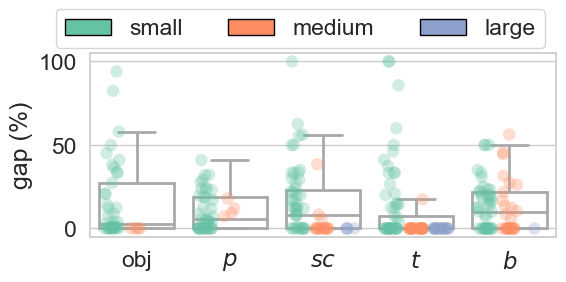

In [84]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 3.4))
size_order = ["small", "medium", "large"]
focus_order =  ["obj","$p$","$sc$","$t$","$b$"]
palette = sns.color_palette("Set2", n_colors=len(size_order))

sns.boxplot(x="focus",  y="gap_perc", order=focus_order, data=my_this_here, ax=ax1, linecolor="darkgray", color="white", linewidth=2, showfliers=False)
sns.stripplot(x="focus",y="gap_perc", order=focus_order, data=my_this_here, ax=ax1, hue="size",  alpha=0.3, jitter=0.25, size=9,dodge=True,palette=palette,hue_order=size_order)
ax1.set_title(None)
ax1.set_ylabel('gap (%)')
ax1.set_xlabel(None)

handles = [Patch(facecolor=palette[i], edgecolor="black", label=str(s))
           for i, s in enumerate(size_order)]
leg = ax1.legend(
    handles=handles, title=None, frameon=True,
    loc="upper right", bbox_to_anchor=(1, 1.3),
    ncols=3
)
plt.tight_layout()
fig.savefig("figures/fig-quality-of-bounds-optimal-known.pdf",bbox_inches='tight')
plt.show()

In [85]:
for i in focus_order:
    tmp = my_this_here.query("focus == @i")
    print(i, tmp.shape[0], tmp.query("gap_perc < 10.0").shape[0], round(100 * tmp.query("gap_perc < 10.0").shape[0] / tmp.shape[0],2))

obj 41 25 60.98
$p$ 43 26 60.47
$sc$ 58 31 53.45
$t$ 81 61 75.31
$b$ 67 32 47.76


In [86]:
# checker
my_this_here["gap_perc"].describe()

count    290.000000
mean      12.722552
std       19.175601
min       -0.000000
25%        0.000000
50%        1.115000
75%       20.000000
max      100.000000
Name: gap_perc, dtype: float64

## Optimum is not known - single objective

In [87]:
# lists_of_optimalslists of optimals for single objectives
tardys = list(tardiness_opt["instance_number"])
setups = list(setupcosts_opt["instance_number"])
runtimes = list(ovenruntime_opt["instance_number"])
batches = list(batchcount_opt["instance_number"])

In [88]:
df_single = pd.read_csv("data/single-no-bounds.csv",sep=";")[["instance_number","int_objective_bound","objective"]].groupby(["instance_number","objective"]).max().reset_index()
df_single = pd.merge(df_single,lb_df,on="instance_number",how="left")
df_single.head()

,instance_number,objective,int_objective_bound,LB_processingTime,LB_setupCost,LB_tardyJobs,LB_tardyJobs_Simple,LB_batchCount,LB_objNormalized,size
0,1,batchcount,7.0,32,10,7,7,6,0.694222,small
1,2,batchcount,6.0,41,7,10,10,5,0.974127,small
2,3,batchcount,7.0,41,0,2,2,6,0.216508,small
3,4,batchcount,3.0,22,7,2,2,3,0.206667,small
4,5,batchcount,4.0,245,56,0,0,4,0.018632,small


In [89]:
tmp = df_single.query("instance_number not in @tardys and objective == 'tardiness'").copy()
tmp["best"] = tmp.apply(lambda row: utils.which_better(sol=row["int_objective_bound"],lb=row["LB_tardyJobs"]), axis=1)
tmp[["instance_number","best","size"]].groupby(["best","size"]).count()

instance_number
best  size                   
calc. large                21
      medium                1
equ.  large                 1
      medium                6
solv. medium               10

In [90]:
tmp = df_single.query("instance_number not in @setups and objective == 'setupcosts'").copy()
tmp["best"] = tmp.apply(lambda row: utils.which_better(sol=row["int_objective_bound"],lb=row["LB_setupCost"]), axis=1)
tmp[["instance_number","best","size"]].groupby(["best","size"]).count()

instance_number
best  size                   
calc. large                36
      medium               25
      small                 1

In [91]:
tmp = df_single.query("instance_number not in @runtimes and objective == 'ovenruntime'").copy()
tmp["best"] = tmp.apply(lambda row: utils.which_better(sol=row["int_objective_bound"],lb=row["LB_processingTime"]), axis=1)
tmp[["instance_number","best","size"]].groupby(["best","size"]).count()

instance_number
best  size                   
calc. large                40
      medium               30
      small                 1
solv. medium                6

In [92]:
tmp = df_single.query("instance_number not in @batches and objective == 'batchcount'").copy()
tmp["best"] = tmp.apply(lambda row: utils.which_better(sol=row["int_objective_bound"],lb=row["LB_batchCount"]), axis=1)
tmp[["instance_number","best","size"]].groupby(["best","size"]).count()

instance_number
best  size                   
calc. large                39
      medium                7
equ.  medium                2
solv. medium                5